# IS53051A Machine Learning Assignment
### Jake Tyler [student number] & Sonny Holland [student number]

# Setting up our notebook


Importing libraries:

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk

Importing the dataset:

In [86]:
dataset = pd.read_csv('datcw_na.csv')

# Data inspection and Visualisation

First, we take a brief look at our dataset:

In [87]:
print(dataset.head(), "\n")
print(dataset.info())

   X0    X1      X2      X3      X4    X5    X6   X7   X8      Y
0  C3  1.19  622.55     NaN   89.31  7.00  1.98  0.0  0.0  15.55
1  C1  1.19  622.55  323.40  109.15  7.70  3.00  0.0  0.0  15.55
2  C1  0.88  463.05  291.06   99.23  5.67  4.40  0.0  0.0  15.55
3  C2  0.79  509.36  291.06  121.28  6.30  4.05  0.0  0.0  15.55
4  C1  0.89  507.15  385.39  121.28  7.70  2.00  0.0  0.0  20.84 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X0      768 non-null    object 
 1   X1      768 non-null    float64
 2   X2      768 non-null    float64
 3   X3      728 non-null    float64
 4   X4      768 non-null    float64
 5   X5      768 non-null    float64
 6   X6      768 non-null    float64
 7   X7      768 non-null    float64
 8   X8      768 non-null    float64
 9   Y       768 non-null    float64
dtypes: float64(9), object(1)
memory usage: 60.1+ KB
None


### Column 'X3' has missing values and column 'X0' is non-numerical,

Below, we can confirm our suspicions that column X3 has 768 entries. We can also identify that 40 values are missing from these entries:

In [88]:
print(f"X3 number of entries: {dataset['X3'].size}")
print(f"X3 missing values: {dataset['X3'].isna().sum()}")

X3 number of entries: 768
X3 missing values: 40


We can also confirm that X0 is a nominal/categorical variable.

The value_counts method also provides the elements in descending order, starting with the most frequently occurring one but this would probably be more useful if we were dealing with a classification problem, not a regression problem.

In [89]:
print("X0 value counts:")
print(dataset["X0"].value_counts())

X0 value counts:
C2    265
C3    260
C1    243
Name: X0, dtype: int64


### Assessing our options for handling missing values and non-numerical categorical data in our dataset before pre-processing,

REWRITE HERE (ONE HOT ENCODING STUFF):
When handling noninal/categorical data we can either drop the column entirely or we can use one hot encoding.

* One-hot encoding: In this technique, a new binary column is created for each category in the categorical feature. Each row in the dataset is assigned a 1 in the corresponding category column and 0 in all other category columns. For example, if we have a categorical feature "color" with values "red", "green", and "blue", we can create three new columns "color_red", "color_green", and "color_blue" and assign binary values based on the presence or absence of each category in each row.

On the other hand, when handling missing values, if the amount is small and randomly distributed it may be reasonable to replace with it the mean, median or mode of the non-missing values.

If the missing values are large or non-random, it may be better to drop the missing values altogether.


We can perform some basic types of analysis to investigate our missing values further:



### Checking the percentage of missing data,

First, we can check the percentage of missing values in our colums. Typically, if the percentage less than 5% we can consider this a small amount:

In [90]:
print("percentage of missing values:")
print(dataset.isna().sum() / dataset.shape[0], "\n")

percentage of missing values:
X0    0.000000
X1    0.000000
X2    0.000000
X3    0.052083
X4    0.000000
X5    0.000000
X6    0.000000
X7    0.000000
X8    0.000000
Y     0.000000
dtype: float64 



Since the percentage of missing values is less than 5% for all columns, it seems reasonable to assume that the missing values are small. While the 'X3' column does have the highest percentage of missing values and exceeds the 5% threshold, the difference is small enough to still consider it small. However, it's important to note that the missing data may still have an impact on the analysis and a decision has not been made on how to handle it.

To continue our investigation, we can conduct a visual inspection to check the distribution:

[NOTE: we can also check correlations on the target variable and different types of correlations]

### Checking the distribution of values in X3,

REWRITE HERE:
To understand the distribution of the missing and non-missing values?, we can use a histogram to gain some visual insights:

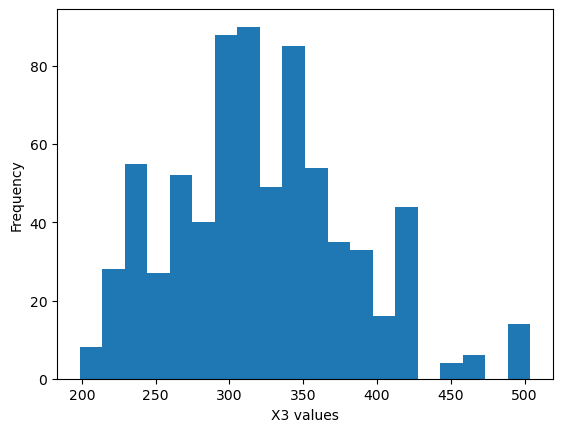

In [91]:
plt.hist(dataset['X3'], bins=20)
plt.xlabel('X3 values')
plt.ylabel('Frequency')
plt.show()

### generate example datasets for visual comparison,

We can also generate some example datasets for a visual comparison to confirm whether the distribution is either random or non-random:

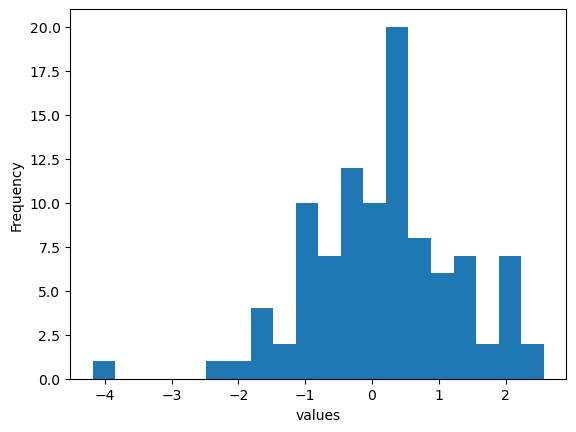

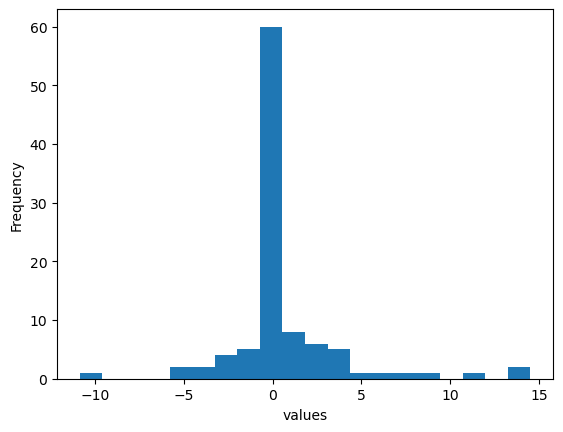

In [92]:
random_dataset = np.random.randn(100)
plt.xlabel('values')
plt.ylabel('Frequency')
plt.hist(random_dataset, bins=20)
plt.show()

nonrandom_dataset = np.random.normal(0, 1, 100) ** 3
plt.xlabel('values')
plt.ylabel('Frequency')
plt.hist(nonrandom_dataset, bins=20)
plt.show()

from the above examples we can conclude that the missing values in X3 are randomly distributed, we can consider imputing the missing values with a reasonable method, such as mean, mode or median to fill in the gaps in the data.

Before making a final decision on the imputation method, it would be good to analyze the relationship between X3 and the target variable Y, to see if the missing values have a significant impact on the results:

array([[<AxesSubplot: xlabel='Y', ylabel='Y'>,
        <AxesSubplot: xlabel='X3', ylabel='Y'>],
       [<AxesSubplot: xlabel='Y', ylabel='X3'>,
        <AxesSubplot: xlabel='X3', ylabel='X3'>]], dtype=object)

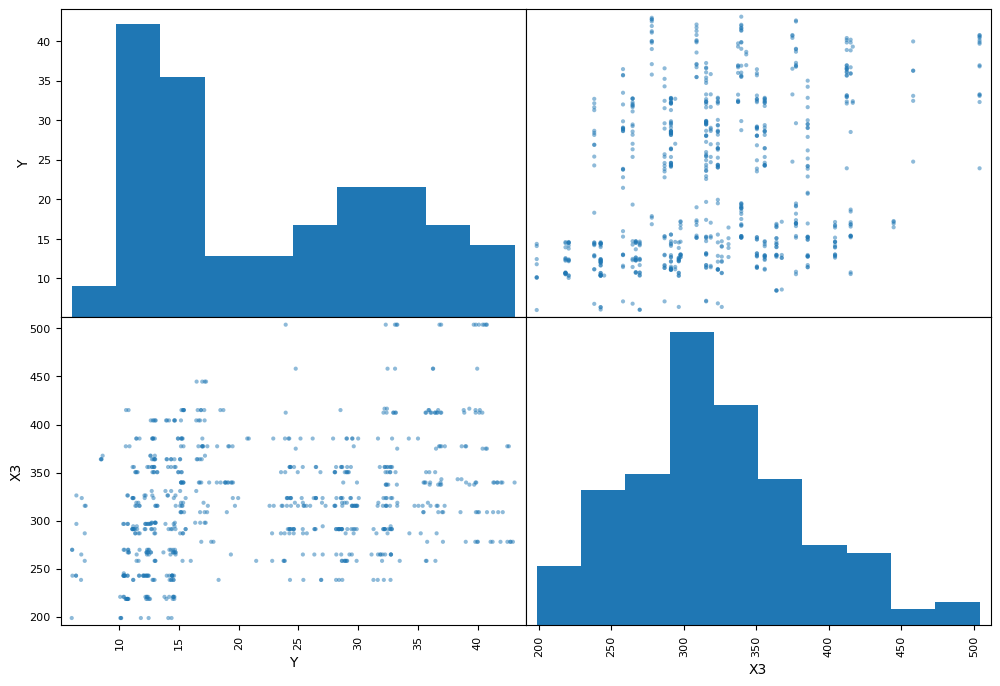

In [93]:
from pandas.plotting import scatter_matrix
attributes = ["Y", "X3"]
scatter_matrix(dataset[attributes], figsize=(12, 8))

In [94]:
# # instantiate multiple copies of the dataset to trial different means of imputation and checking its
# # effect on the correlation between X3 and Y

# dataset_for_mean = dataset.copy()
# dataset_for_median = dataset.copy()
# dataset_for_random_drop_mean = dataset.copy()

# # Calculate the percentage of missing values in X3
# missing_X3 = dataset_for_random_drop_mean['X3'].isna().mean()

# # Replace missing values in column X3 with the mean value, and the other copy with the median value
# median_X3 = dataset_for_median['X3'].median()
# mean_X3 = dataset_for_mean['X3'].mean()
# dataset_for_mean['X3'].fillna(mean_X3, inplace=True)
# dataset_for_median['X3'].fillna(median_X3, inplace=True)

# # Calculate the correlation between X3 and Y for the mean imputed dataset
# correlation_with_mean = dataset_for_mean[['X3', 'Y']].corr().loc['X3', 'Y']

# # Calculate the correlation between X3 and Y for the median imputed dataset
# correlation_with_median = dataset_for_median[['X3', 'Y']].corr().loc['X3', 'Y']

# # Create a copy of the dataset with randomly dropped values in X3
# dataset_for_random_drop_mean['X3'] = dataset_for_random_drop_mean['X3'].apply(lambda x: np.nan if np.random.rand() < missing_X3 else x)

# # Replace missing values in the random_drop dataset with the mean value
# dataset_for_random_drop_mean['X3'].fillna(mean_X3, inplace=True)

# # Replace missing values in the random_drop dataset with the median value
# dataset_for_random_drop_mean['X3'].fillna(median_X3, inplace=True)

# # Calculate the correlation between X3 and Y in the random_drop dataset
# correlation_with_random_drop = dataset_for_random_drop_mean[['X3', 'Y']].corr().loc['X3', 'Y']

# # Create a copy of the dataset with randomly dropped values in X3 and median imputation
# dataset_for_random_drop_median = dataset.copy()
# dataset_for_random_drop_median['X3'] = dataset_for_random_drop_median['X3'].apply(lambda x: np.nan if np.random.rand() < missing_X3 else x)
# dataset_for_random_drop_median['X3'].fillna(median_X3, inplace=True)

# # Calculate the correlation between X3 and Y in the random_drop and median imputed dataset
# correlation_with_random_drop_median = dataset_for_random_drop_median[['X3', 'Y']].corr().loc['X3', 'Y']

# # Print the correlation results
# print(f"Correlation between X3 and Y with without any imputation methods: {dataset['X3'].corr(dataset['Y']):.3f}")
# print(f"Correlation between X3 and Y with mean imputation: {correlation_with_mean:.3f}")
# print(f"Correlation between X3 and Y with random drop and mean imputation: {correlation_with_random_drop:.3f}")
# print(f"Correlation between X3 and Y with median imputation: {correlation_with_median:.3f}")
# print(f"Correlation between X3 and Y with random drop and median imputation: {correlation_with_random_drop_median:.3f}")

In [95]:
# calculate the correlation between X3 and Y without replacing missing values
corr_raw = dataset['X3'].corr(dataset['Y'])

# calculate the correlation between X3 and Y with mean, mode, and median imputation
corr_mean = dataset['X3'].fillna(dataset['X3'].mean()).corr(dataset['Y'])
corr_mode = dataset['X3'].fillna(dataset['X3'].mode()[0]).corr(dataset['Y'])
corr_median = dataset['X3'].fillna(dataset['X3'].median()).corr(dataset['Y'])

# randomly drop 20% of the rows in the dataset to simulate missingness
dataset_random_drop = dataset.drop(np.random.choice(dataset.index, size=int(len(dataset)*0.2), replace=False))

# calculate the correlation between X3 and Y with mean, mode, and median imputation with random drops
corr_mean_random = dataset_random_drop['X3'].fillna(dataset_random_drop['X3'].mean()).corr(dataset_random_drop['Y'])
corr_mode_random = dataset_random_drop['X3'].fillna(dataset_random_drop['X3'].mode()[0]).corr(dataset_random_drop['Y'])
corr_median_random = dataset_random_drop['X3'].fillna(dataset_random_drop['X3'].median()).corr(dataset_random_drop['Y'])

print(f"Correlation between X3 and Y (without imputation): {corr_raw}", '\n')

print(f"Correlation between X3 and Y (mean imputation): {corr_mean}")
print(f"Correlation between X3 and Y (mean imputation and random drop): {corr_mean_random}", '\n')

print(f"Correlation between X3 and Y (mode imputation): {corr_mode}")
print(f"Correlation between X3 and Y (mode imputation and random drop): {corr_mode_random}", '\n')

print(f"Correlation between X3 and Y (median imputation): {corr_median}")
print(f"Correlation between X3 and Y (median imputation and random drop): {corr_median_random}", '\n')




# create a dictionary to store the correlation values for each imputation method
corr_dict = {
    'raw': corr_raw, # should we drop this
    'mean': corr_mean,
    'mode': corr_mode,
    'median': corr_median,
    'mean_random': corr_mean_random,
    'mode_random': corr_mode_random,
    'median_random': corr_median_random
}

# find the imputation method with the highest correlation with the target variable
best_imputation = max(corr_dict, key=corr_dict.get)

# print the results
print(f"Best imputation method for X3: {best_imputation}")
print(f"Correlation with Y: {corr_dict[best_imputation]}")


# It depends on the specific circumstances and goals of your machine learning project.
# In some cases, using the raw dataset without any imputation method might be the best
# option. This could be the case if the missing data is truly missing at random and
# there is no systematic bias in the missing data.

# However, in many cases, simply ignoring missing values and using the raw dataset
# could lead to biased or inaccurate results. For example, if the missing data is
# related to the target variable or another important feature, then ignoring it could
# result in a model that does not capture important patterns in the data.

# Therefore, it is important to carefully consider the specific characteristics of
# your dataset and the goals of your machine learning project when deciding whether
# to use the raw dataset or an imputed dataset. Additionally, you may want to consider
# alternative methods for handling missing values, such as model-based imputation or
#     multiple imputation, which can provide more accurate and reliable results.


Correlation between X3 and Y (without imputation): 0.3124488952355989 

Correlation between X3 and Y (mean imputation): 0.30511448543332886
Correlation between X3 and Y (mean imputation and random drop): 0.293106115022126 

Correlation between X3 and Y (mode imputation): 0.30796491944608173
Correlation between X3 and Y (mode imputation and random drop): 0.2966178237297222 

Correlation between X3 and Y (median imputation): 0.3059704038634418
Correlation between X3 and Y (median imputation and random drop): 0.2942685980272344 

Best imputation method for X3: raw
Correlation with Y: 0.3124488952355989


### REWRITE ALL THIS, MAKE IT LESS GPT'Y

SONNYS BIT: the preceeding code suggests that our choice of imputation has very little affect on the ecology of the dataset, one would expect the use of dropping random values would have a greater impact on the correlation between X3 and Y albeit a negative one, given the ham-fisted nature of this method. For the sake of this exercise we will proceed with the median imputation method. But in other cases it may be worth exploring other means of imputation, such as regression imputation or multiple imputation, to see if they produce more robust results. Alternatively, you may want to consider using analysis methods that are more tolerant to missing data, such as bootstrapping or Bayesian analysis.


The correlation between X3 and Y with mean imputation is 0.305 and the correlation between X3 and Y with 
random drop and mean imputation is 0.293.

This suggests that imputing missing values in X3 with the mean value has a small positive impact on 
the correlation between X3 and Y, indicating that there is a weak positive linear relationship between 
the two variables. However, the difference between the two correlation values is relatively small,
suggesting that the choice of imputation method may not have a significant impact on the analysis.

Based on these results, you can conclude that the two imputation methods produce similar results,
but there may be some variability due to missing data. You may then want to explore other
imputation methods, such as regression imputation or multiple imputation, to see if they
produce more robust results. Alternatively, you may want to consider using analysis methods 
that are more tolerant to missing data, such as bootstrapping or Bayesian analysis.


-------------------------------------------------------------------------------------------
Based on the information provided, it seems reasonable to replace the missing values in column X3 with the mean value as the percentage of missing values is relatively low (5.2%).

Additionally, X3 appears to have a moderate positive correlation with the target variable Y
(correlation coefficient of 0.31), indicating that it may be a useful feature in predicting Y.

Therefore, it's important to carefully evaluate the data and consider other imputation methods, such as using a regression model to predict missing values based on the values of other variables, if appropriate.

Based on the information provided, it seems reasonable to replace the missing values in column X3 with the mean value, as the percentage of missing values is relatively low (5.2%). Additionally, X3 appears to have a moderate positive correlation with the target variable Y (correlation coefficient of 0.31), indicating that it may be a useful feature in predicting Y.

However, before deciding to replace missing values with the mean, it's important to consider the nature of the data and the potential impact of imputing missing values on the analysis results. For instance, if X3 has a significant number of extreme values or outliers, then the mean may not be a representative measure of central tendency, and imputing missing values with the mean could distort the distribution of the data.

# Data preprocessing

First, we compute a correlation matrix, this informs our data stratification as we want to make decisions upon the features that correlate best to our target variable. Also down the line, we will perform feature selection, based on the correlation matrix; we will be dropping columns with a low correlation to our target variable:

In [96]:
corr_matrix = dataset.corr()
corr_matrix["Y"].sort_values(ascending=False)

/var/folders/4t/8hjy6t1s4v9_4wgdjp2xb_m00000gn/T/ipykernel_3904/609732122.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = dataset.corr()


Y     1.000000
X5    0.815769
X1    0.454177
X3    0.312449
X7    0.255901
X8    0.087106
X6    0.001340
X2   -0.481192
X4   -0.771040
Name: Y, dtype: float64

### Split the data into train and test sets, for model training and evaluation, respectively

### Data preprocessing

Feature selection

In [97]:
print(dataset.shape)

(768, 10)


In [98]:
dataset_fs = dataset.copy()
def drop_correlation_columns(data, threshold):
    features_to_drop = list(
        dataset.corr()[abs(dataset.corr()['Y']) < threshold].index)
    print('Dropping following labels: ', features_to_drop)
    data.drop(features_to_drop, axis=1, inplace=True)
    return data

dataset_fs = drop_correlation_columns(dataset_fs, 0.25)
print(dataset.shape)
print(dataset_fs.shape)

Dropping following labels:  ['X6', 'X8']
(768, 10)
(768, 8)


/var/folders/4t/8hjy6t1s4v9_4wgdjp2xb_m00000gn/T/ipykernel_3904/1915178434.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dataset.corr()[abs(dataset.corr()['Y']) < threshold].index)


One hot encoding

In [99]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# as already discussed 'x0' is a categorical feature of the dataset, 
# thus we need to use one-hot encoding to convert the feature into a numerical representation

encoder = OneHotEncoder(sparse_output=False)
encoder_fs = OneHotEncoder(sparse_output=False)
onehot_X0 = encoder.fit_transform(dataset['X0'].values.reshape(-1, 1))
onehot_X0_fs = encoder_fs.fit_transform(dataset_fs['X0'].values.reshape(-1, 1))
dataset = dataset.drop('X0', axis=1)
dataset_fs = dataset_fs.drop('X0', axis=1)
dataset = pd.concat([dataset, pd.DataFrame(onehot_X0)], axis=1)
dataset_fs = pd.concat([dataset_fs, pd.DataFrame(onehot_X0_fs)], axis=1)

Data imputation

In [100]:
# 'x3' has missing values, so we need to impute the missing values before we can use it, as already deduced in the notebook
# we will use the median value to impute the missing values

median_X3 = dataset['X3'].median()
median_X3_fs = dataset_fs['X3'].median()
dataset['X3'].fillna(median_X3, inplace=True)
dataset_fs['X3'].fillna(median_X3_fs, inplace=True)

Train test split

In [101]:
from sklearn.model_selection import StratifiedShuffleSplit
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

# split the dataset into train and test sets,
# note: we are using X[4] as our target variable, this is the the 'OverallHeight' feature, we stratify based upon this feature, as it has 
# the highest correlation with the target variable

# convert X to a pandas dataframe so we can use the loc function
for train_index, test_index in stratified_split.split(dataset, dataset['X5']):
    train_set = dataset.loc[train_index]
    test_set = dataset.loc[test_index]

for train_index, test_index in stratified_split.split(dataset_fs, dataset_fs['X5']):
    train_set_fs = dataset_fs.loc[train_index]
    test_set_fs = dataset_fs.loc[test_index]

In [102]:
print(dataset_fs.columns)
print(train_set_fs.columns)

Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X7', 'Y', 0, 1, 2], dtype='object')
Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X7', 'Y', 0, 1, 2], dtype='object')


Standard scaler

In [103]:
# scale the features

train_set.columns = train_set.columns.astype(str)
test_set.columns = test_set.columns.astype(str)

train_set_fs.columns = train_set_fs.columns.astype(str)
test_set_fs.columns = test_set_fs.columns.astype(str)

train_scaler = StandardScaler()
test_scaler = StandardScaler()

train_scaler_fs = StandardScaler()
test_scaler_fs = StandardScaler()

train_set = train_scaler.fit_transform(train_set)
test_set = test_scaler.fit_transform(test_set)

train_set_fs = train_scaler_fs.fit_transform(train_set_fs)
test_set_fs = test_scaler_fs.fit_transform(test_set_fs)

In [104]:
print(train_set.shape)
print(test_set.shape)

print(train_set_fs.shape)
print(test_set_fs.shape)

(537, 12)
(231, 12)
(537, 10)
(231, 10)


Split X and y

In [105]:
X_train = np.delete(train_set, 9, axis=1)
y_train = train_set[:, 9]
X_test = np.delete(test_set, 9, axis=1)
y_test = test_set[:, 9]

X_train_fs = np.delete(train_set_fs, 9, axis=1)
y_train_fs = train_set_fs[:, 9]
X_test_fs = np.delete(test_set_fs, 9, axis=1)
y_test_fs = test_set_fs[:, 9]

# Instantiating our models

Luckily for us, the sklearn API provides a GridSearchCV class, allowing us to iterate through a list of pipelines and models, evaluating their performance against one another, to find the optimal choice for the problem at hand; hyper parameters can also be deliberated upon within this process. Furhtermore, all of the models bar one (Polynomial regression) are already created in the sklearn API, so we can simply instantiate them, and pass them into the grid search.

### Creating a polynomial regression model with regularisation

Unfortunately, unlike all the other models relevant to this analysis, the polynomial regression model isn't implemented within the sk-learn API. So we must create this manually. To ensure this works with the modularity concepts we have put in place elsewhere within the code, the implementation of this model is done so in accordance to the sk-learn pipeline API. This means that the model can be passed into the grid search, and the hyper parameters can be deliberated upon.

In [106]:
# REWRITE: Note that we import BaseEstimator and RegressorMixin from sklearn.base, and we define PolynomialRegression as 
# a subclass of both BaseEstimator and RegressorMixin. This allows us to use PolynomialRegression as a fully-fledged estimator 
# within the sklearn ecosystem.

from sklearn.preprocessing import PolynomialFeatures
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.pipeline import Pipeline

class PolynomialRegression(BaseEstimator, RegressorMixin):
    def __init__(self, degree=2):
        self.degree = degree
        self.model = Pipeline([
            ('poly', PolynomialFeatures(degree=self.degree)),
            ('ridge', Ridge(alpha=0.1))
        ])
    
    def fit(self, X, y):
        self.model.fit(X, y)
    
    def predict(self, X):
        return self.model.predict(X)
    
    def score(self, X, y):
        return self.model.score(X, y)
    
    def set_params(self, **params):
        for param, value in params.items():
            if param.startswith('poly__'):
                setattr(self.model.named_steps['poly'], param[len('poly__'):], value)
            else:
                setattr(self.model, param, value)
        return self

### Instantiating all other models

In [107]:
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'PolynomialRegression': PolynomialRegression()
}

# we also define a dictionary of hyperparameters to be searched for each respective model,
# will be iterated through matching the keys to the models dictionary

param_grid = {
    'LinearRegression': {},
    'Ridge': {'alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0]},
    'Lasso': {'alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0]},
    'ElasticNet': {'alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0], 'l1_ratio': [0.1, 0.5, 0.9, 1.0]},
    'PolynomialRegression': {'polynomialfeatures__degree': [2, 3, 4, 5], 'ridge__alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0]}
}

### Perform grid search and save results

In [108]:
print(X_train.shape)
print(X_train_fs.shape)

(537, 11)
(537, 9)


In [109]:
from sklearn.model_selection import GridSearchCV
trained_models = {}
param_results = {}
results = []


for model_name, model in models.items():
    params = param_grid[model_name]
    grid_search = GridSearchCV(
        model, params, scoring='neg_mean_absolute_percentage_error', cv=5, n_jobs=1)
    grid_search_fs = GridSearchCV(
        model, params, scoring='neg_mean_absolute_percentage_error', cv=5, n_jobs=1)
    grid_search.fit(X_train, y_train)
    grid_search_fs.fit(X_train_fs, y_train_fs)
    trained_models[model_name] = grid_search.best_estimator_
    trained_models[model_name + '_fs'] = grid_search_fs.best_estimator_
    param_results[model_name] = grid_search.best_params_
    param_results[model_name + '_fs'] = grid_search_fs.best_params_
    results.append({
        'model': model_name,
        'best_score': grid_search.best_score_,
        'best_params': grid_search.best_params_,
    })
    results.append({
        'model': model_name + '_fs',
        'best_score': grid_search_fs.best_score_,
        'best_params': grid_search_fs.best_params_
    })


In [110]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by=['best_score'], ascending=False)
results_df = results_df.reset_index(drop=True)
results_df

,model,best_score,best_params
0,LinearRegression_fs,-8.087136e-16,{}
1,LinearRegression,-1.020892e-15,{}
2,Ridge_fs,-4.756288e-05,{'alpha': 0.01}
3,Ridge,-4.868050e-05,{'alpha': 0.01}
4,PolynomialRegression_fs,-2.108612e-04,"{'polynomialfeatures__degree': 2, 'ridge__alph..."
5,PolynomialRegression,-2.426127e-04,"{'polynomialfeatures__degree': 2, 'ridge__alph..."
6,ElasticNet_fs,-1.986714e-02,"{'alpha': 0.01, 'l1_ratio': 0.1}"
7,Lasso_fs,-2.013232e-02,{'alpha': 0.01}
8,ElasticNet,-2.033074e-02,"{'alpha': 0.01, 'l1_ratio': 0.1}"
9,Lasso,-2.044361e-02,{'alpha': 0.01}


### Evaluate on the two best models

In [111]:
trained_models['Lasso'].set_params(**param_results['Lasso']).score(X_test, y_test)

0.9981573907452783

In [112]:
trained_models['ElasticNet'].set_params(**param_results['ElasticNet']).score(X_test, y_test)

0.9981620374030648